## Install mplcairo backend first

```bash
pip install numpy pandas matplotlib pycairo Pillow
pip install git+https://github.com/anntzer/mplcairo
```


## Import modules, set plot styles & some color functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import mplcairo
mpl.use("module://mplcairo.base")
import matplotlib.pyplot as plt

# use floating point surfaces for lines with tiny alpha values
mplcairo.set_options(float_surface=True)

# use best antialiasing
# https://github.com/matplotlib/mplcairo?tab=readme-ov-file#antialiasing
from mplcairo import antialias_t
dict.__setitem__(plt.rcParams, "lines.antialiased", antialias_t.BEST)
dict.__setitem__(plt.rcParams, "patch.antialiased", antialias_t.BEST)
dict.__setitem__(plt.rcParams, "text.antialiased", antialias_t.GRAY)

# general theme
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [2]:
########### Ordinal Encoder ###########
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

In [3]:
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

def img2cmap(fname, name=None, reversed=False):
    cmap_arr = np.array(Image.open(fname))[0].astype(np.float64) / 255.0
    return LinearSegmentedColormap.from_list(
        (name or fname) + ('_r' if reversed else ''),
        np.flip(cmap_arr, 0) if reversed else cmap_arr
    )

def get_color(cmap, val, alpha):
    color = cmap(val)
    color = list(color)
    if len(color) == 4:
        color[3] = alpha
    elif len(color) == 3:
        color.append(alpha)
    else:
        raise ValurError(color)
    return tuple(color)


In [4]:
# colors

from matplotlib.colors import to_rgba

def choose_color(num):
    if num == 0:
        color="khaki"
    elif num == 1:
        color="yellowgreen"
    elif num == 2:
        color="lightskyblue"
    elif num == 3:
        color="dimgray"
    else:
        print("pick an integer from 0 to 2")
    return to_rgba(color)

    
        

In [5]:
# Uploading and reading the file
plot_df = pd.read_csv('Top3_Prediction.csv')#.sample(n=100, ignore_index=True)

#Constructing Relative_Standard_Deviation column
plot_df['Relative_Standard_Deviation'] = np.clip(plot_df['Fold_Increase_STD'] / plot_df['Fold_Increase'], 0, 1)

#Creating Relative_Standard_Deviation categories
bins = [0,0.1,0.2]
labels = [0.1,0.2]
plot_df['Relative_Standard_Deviation_cat']=pd.cut(plot_df['Relative_Standard_Deviation'],bins= bins,labels=labels)
plot_df['Relative_Standard_Deviation_cat']= plot_df['Relative_Standard_Deviation_cat'].astype(object).fillna(plot_df['Relative_Standard_Deviation'])                                                

#Introducting a new parameter - Combined Effect                                                 
plot_df['Combined_Effect']=plot_df['Fold_Increase'] /plot_df['Relative_Standard_Deviation_cat'] 
                                             

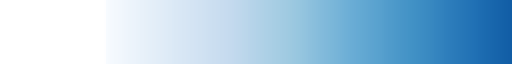

In [6]:
######### Combined Effect - Assigning columns, parameters #########
Y_COL = 'Combined_Effect'
Y_MIN, Y_MAX = 0, 300
higher_is_better = True
sorting_randomness = 0.7

##### Color Map #####
cmap = img2cmap('Partial_blue.png', 'custom_coolwarm', reversed=not higher_is_better)
display(cmap)


###Assinging Columns
y_cols = [
    'Day1_H2O2', 'Day2_H2O2', 'Day3_H2O2',
    'Day1_Lysozyme', 'Day2_Lysozyme', 'Day3_Lysozyme',
    'Day1_Sonication','Day2_Sonication' , 'Day3_Sonication',
    Y_COL
]

###Extracting Column Names
y_names = [y.replace('_', '\n').replace('Day', 'Day ').replace('H2O2', '$H_2O_2$') for y in y_cols]

###Assinging Columns Tick Values
y_ticks = [{
    'H2O2': [0, 10, 25, 50],
    'Lysozyme': [0, 0.75, 1.5, 2.25, 3.0],
    'Sonication': [0, 20, 30, 60],
    'Effect': np.linspace(Y_MIN, Y_MAX, 4),
    'Standard': np.linspace(Y_MIN, Y_MAX, 5),
}[y.split('_')[1]] for y in y_cols]

### Calculating Aplha values
line_values = plot_df[Y_COL].values / Y_MAX
line_alphas = np.clip(line_values, 0, 1)

if Y_COL == 'Combined_Effect':
    line_alphas = (np.abs((line_alphas - 0.5) * 2) ** 4) * 0.9 + 0.006
else:
    print('line_alphas transform skipped')

input_cols = y_cols[0:-1]
cat_H = ["0", "10", "25", "50"]
cat_L = ["0", "0.75", "1.5", "2.25", "3"]
cat_S = ["0", "20", "30", "60"]

agg_norm_values =[[],[],[]]

shift = 0

# Initialize an empty array to store aggregated normalized values
agg_norm_values = np.empty((plot_df.shape[0], 0))

# Loop through the input columns
for col in input_cols:

    # Extract the last part of the column name
    cat_str = col.split("_")[-1]
    
    # Match with the correct category list
    if cat_str == "H2O2":
        cat_list = sorted(set(cat_H))
    elif cat_str == "Lysozyme":
        cat_list = sorted(set(cat_L))
    elif cat_str == "Sonication":
        cat_list = sorted(set(cat_S))
    else:
        print(f"No match for column: {col}")
        continue  # Skip to the next column
    
    # Assign categories to the Ordinal Encoder
    emc = OrdinalEncoder(categories=[cat_list], dtype=object, handle_unknown="use_encoded_value", unknown_value=-1)
    
    # Transform the column values
    try:
        # norm_values = emc.fit_transform(plot_df[[col]])
        norm_values = emc.fit_transform(plot_df[[col]].astype(str))
        # Aggregate normalized values
        agg_norm_values = np.hstack((agg_norm_values, norm_values))
    except Exception as e:
        print(f"Error processing column {col}: {e}")
      


In [7]:
# Applying the shift
base_0 = np.array([[1,1,1],
                  [1,1,1],
                  [1,1,1],
                  [1,1,1]])

factor_1 = np.array([0.05,0.1,0,0.05])
factor_1 = factor_1[:,np.newaxis]
shift_1 = base_0 * factor_1

factor_2 = np.array([0.25,0.10,0.00,0.03])
factor_2 = factor_2[:,np.newaxis]
shift_2 = base_0 * factor_2

factor_3 = np.array([0.09,0.05,0.05,0.05])
factor_3 = factor_3[:,np.newaxis]
shift_3= base_0 * factor_3

shift = np.concatenate((shift_1,shift_2,shift_3), axis=1)
agg_norm_values=agg_norm_values+ shift

In [8]:
# Normalizing the Input matrix and assigning aplha values
y_values = plot_df[y_cols].values
norm_y_values=np.hstack((agg_norm_values, y_values[:,-1:]))
line_values = plot_df[Y_COL].values / Y_MAX
line_alphas = np.clip(line_values, 0, 1)

## Load prediction result and prepare data

## Parallel Coordinates Plot 

In [9]:
from matplotlib.path import Path
import matplotlib.patches as patches


In [10]:
# Evaluating mins and max  to normalizing the data 
y_maxs= np.array([3.2,3.2,3.2,4.2,4.2,4.2,3.2,3.2,3.2])
y_mins = np.zeros_like(y_maxs)
y_deltas = y_maxs - y_mins
y_min_l =np.array(norm_y_values[:,-1].min(axis=0))
y_max_l =np.array(norm_y_values[:,-1].max(axis=0))
y_mins=np.hstack((y_mins,y_min_l))
y_maxs=np.hstack((y_maxs,y_max_l))


In [11]:
# transform all data to be compatible with the main axis
z_values = np.zeros_like(norm_y_values)
z_values[:, 0] = norm_y_values[:, 0]
z_values
num_cols = z_values.shape[1]
num_row =z_values.shape[0]

for i in range(1,num_cols):
    
    if y_maxs[i] ==0:
         for j in range(0,num_row):
            z_values[j, i] = 0         
    else:
        if i >=3 and i<6:
            max=4
        elif i==9:
            max=y_maxs[9]
        else:
            max=3
        
        for j in range(0,num_row):
            z_values[j, i] = (norm_y_values[j, i] - 0) / max * 3+ 0
z_values


array([[1.05, 1.05, 0.05, 0.1875, 3.1875, 0.1875, 0.09, 3.09, 0.09, 3.0],
       [1.1, 1.1, 1.1, 0.07500000000000001, 0.07500000000000001,
        3.0749999999999997, 0.05, 2.05, 2.05, 2.8499999999999996],
       [3.0, 3.0, 3.0, 0.0, 3.0, 0.0, 0.05, 2.05, 0.05,
        2.8499999999999996],
       [0.05, 0.05, 0.05, 0.0225, 0.0225, 0.0225, 0.05, 0.05, 0.05,
        0.0529287226534933]], dtype=object)

In [12]:
# Setting up the axes
plt.close('all')
fig, host = plt.subplots(figsize=(12, 4), gridspec_kw=dict(left=0.1, right=0.95, bottom=0.1, top=0.8))

axes = [host] + [host.twinx() for i in range(norm_y_values.shape[1]-1)]

for i, ax in enumerate(axes):
    ax.set_ylim(y_mins[i], y_maxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    if i == (len(axes) - 1):
        ax.set_yticks([])
        ax.set_ylim(-0.1, Y_MAX)
    else:
        ax.set_yticks(list(range(len(y_ticks[i]))), labels=list(map(str, y_ticks[i])))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (y_values.shape[1] - 1)))
    ax.tick_params(axis='y', which='major', labelsize=12)

host.set_xlim(0, y_values.shape[1]-1 )
host.set_xticks(range(y_values.shape[1]-1))
host.set_xticklabels(y_names[:-1], fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()

cbar = plt.colorbar(
    mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=Y_MIN, vmax=Y_MAX), cmap),
    ax=axes[-1], pad=0, shrink=1, fraction=0.05
)
cbar.ax.set_ylabel(y_names[-1].replace('\n', ' '), fontsize=14, labelpad=10)
cbar.ax.tick_params(axis='y', which='major', labelsize=12)



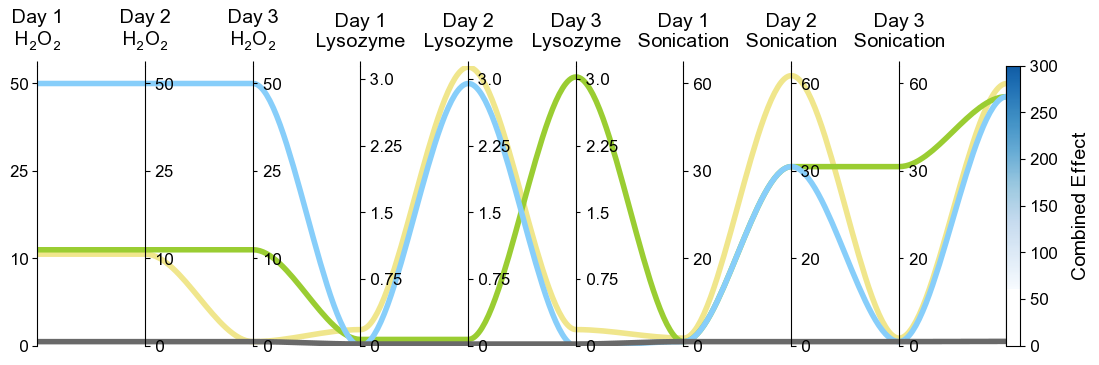

In [13]:
for j in range(norm_y_values.shape[0]):
   
    # create bezier curves
    verts = list(zip([x for x in np.linspace(0, 9, 10 * 3 - 2, endpoint=True)],
                     np.repeat(z_values[j, :], 3)[1:-1]))
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor="none", 
                              lw=4, 
                              edgecolor=choose_color(j), )
    host.add_patch(patch)
 
    
# host.legend(["T1","T2","T3"],loc=4)
fig.savefig(f'FlowGraph.{Y_COL}.png', dpi=300, transparent=True)

fig